# Spherical harmonic models 

In [3]:
# Import notebook dependencies

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from src import sha, mag, lsfile, cfile, IGRF13_FILE

# Part 1: Spherical harmonics and representing the geomagnetic field
The north (X), east (Y) and vertical (Z) (downwards) components of the internally-generated geomagnetic field at colatitude ${θ}$, longitude ${ϕ}$ and radial distance $r$ (in geocentric coordinates with reference radius $a=6371.2$ km for the IGRF) are written as follows:

\begin{align}
X & = \sum_{n=1}^N (\frac{a}{r})^{n+2}\left[g^0_n X^0_n + \sum_{m=1}^M(g^m_n cos(m\phi) + h^m_n sin(m\phi))X^m_n\right]\tag{1}\\
Y & = \sum_{n=1}^N (\frac{a}{r})^{n+2}\left[\sum_{m=1}^M(g^m_n sin(m\phi)) - h^m_n cos(m\phi))Y^m_n\right]\tag{2}\\
Z & = \sum_{n=1}^N (\frac{a}{r})^{n+2}\left[g^0_n Z^0_n + \sum_{m=1}^M(g^m_n cos(m\phi) + h^m_n sin(m\phi))Z^m_n\right]\tag{3} \quad\quad\quad\quad\\
\text{with}\\
X^m_n & = \frac{dP^m_n}{d\theta}\tag{4}\\
Y^m_n & = \frac{m}{sin\theta}P^m_n, \quad\quad \text{(expect at the poles where $Y^m_n=X^m_n cos\theta)$)}\tag{5}\\
X^m_n & = -(n+1)P^m_n\tag{6}  
\end{align}

where $n$ and $m$ are spherical harmonic degree and order, respectively, and the ($g^m_n,h^m_n$) are the Gauss coefficients for a particular model (e.g. the IGRF) of maximum degree $N$
The Associated Legendre functions of degree $n$ and order $m$ are defined, in Schmidt semi-normalised form by:

\begin{align}
P^m_n(x) & = \frac{1}{2^n{n!}}\left[\frac{(2-\delta_{0m}{(n-m)!(1-x^2)^m})}{(n+m)!}\right]^\frac{1}{2}\frac{d^{n+m}}{dx^{n+m}}(1-x^2)^n\tag{7},
\end{align}
where $x=cos(\theta)$, where {\theta} denotes geocentric colatitude. Referring to Malin and Barraclough (1981), the recurrence relations
\begin{align}
P^n_n & = \Biggl(1- \frac{1}{2n}\Biggr)^\frac{1}{2}sin\theta P^{n-1}_{n-1}\tag{8}\\
P^m_n(x) & = \left[(2n-1)cos\theta P^{m}_{n-1}-\left[(n-1)^{2}-m^{2}\right]^\frac{1}{2}P^{m}_{n-2}\right]{(n^{2}-m^{2})}^\frac{-1}{2}\tag{9}\\
and\\
X^n_n & = \Biggl(1- \frac{1}{2n}\Biggr)^\frac{1}{2}(sin\theta X^{n-1}_{n-1}+cos\theta P^{n-1}_{n-1})\tag{10}\\
X^m_n & = \left[(2n-1)cos\theta X^{m}_{n-1}-sin\theta P^{m}_{n-1}\right]-\left[(n-1)^{2}-m^{2}\right]^\frac{1}{2}X^{m}_{n-2}{(n^{2}-m^{2})}^\frac{-1}{2}\tag{11}.
\end{align}

may be used to calculate the $X^m_n$, $Y^m_n$ and $Z^m_n$, given $P^0_0=1$, $P^1_1=sin(\theta)$, $X^0_0=0$ and $X^1_1=cos(\theta)$


# 1- Plotting $P^m_n$ and $X^m_n$:

The $P^m_n{(\theta)}$ and $X^m_n{(\theta)}$ are building blocks for computing geomagnetic field models given a spherical harmonic model. It's instructive to visualise these functions and below you can experiment by setting different values of spherical harmonic degree ($n$) and order ($m\le{n}$). Note how the choice of  and  affects the number of zeroes of the functions.
The functions are plotted on a semi-circle representing the surface of the Earth, with the inner core added for cosmetic purposes only! Again, purely for cosmetic purposes, the functions are scaled to fit within ${\pm}$10% of the Earth's surface.

**>> Set the spherical harmonic degree and order for the plot**

In [4]:
degree = 13
order  = 8

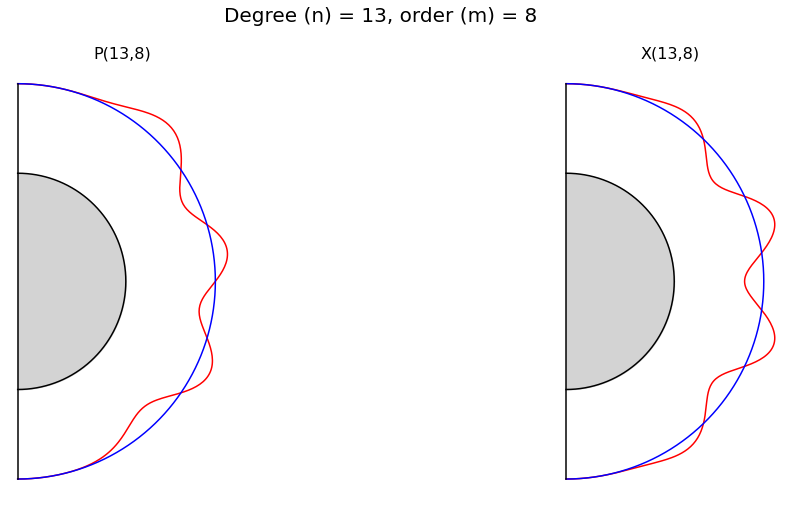

In [5]:
# Calculate Pnm and Xmn values every 0.5 degrees
colat   = np.linspace(0,180,361)
pnmvals = np.zeros(len(colat))
xnmvals = np.zeros(len(colat))

idx     = sha.pnmindex(degree,order)
for i, cl in enumerate(colat):
    p,x = sha.pxyznm_calc(degree, cl)[0:2]
    pnmvals[i] = p[idx]
    xnmvals[i] = x[idx]
    
theta   = np.deg2rad(colat)
ct      = np.cos(theta)
st      = np.sin(theta)

# Numbers mimicking the Earth's surface and outer core radii
e_rad   = 6.371 # Earth's surface radii
c_rad   = 3.485 # outer core radii

# Scale values to fit within 10% of "Earth's surface". Firstly the P(n,m),
shell   = 0.1*e_rad
pmax    = np.abs(pnmvals).max()
pnmvals = pnmvals*shell/pmax + e_rad
xp      = pnmvals*st
yp      = pnmvals*ct

# and now the X(n,m)
xmax    = np.abs(xnmvals).max()
xnmvals = xnmvals*shell/xmax + e_rad
xx      = xnmvals*st
yx      = xnmvals*ct

# Values to draw the Earth's and outer core surfaces as semi-circles
e_xvals = e_rad*st
e_yvals = e_rad*ct
c_xvals = e_xvals*c_rad/e_rad
c_yvals = e_yvals*c_rad/e_rad

# Earth-like background framework for plots
def eplot(ax):
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.plot(e_xvals,e_yvals, color='blue')
    ax.plot(c_xvals,c_yvals, color='black')
    ax.fill_between(c_xvals, c_yvals, y2=0, color='lightgrey')
    ax.plot((0, 0), (-e_rad, e_rad), color='black')

# Plot the P(n,m) and X(n,m)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
fig.suptitle('Degree (n) = '+str(degree)+', order (m) = '+str(order), fontsize=20)
                    
axes[0].plot(xp,yp, color='red')
axes[0].set_title('P('+ str(degree)+',' + str(order)+')', fontsize=16)
eplot(axes[0])

axes[1].plot(xx,yx, color='red')
axes[1].set_title('X('+ str(degree)+',' + str(order)+')', fontsize=16)
eplot(axes[1])

# 2- The International Geomagnetic Reference Field
The latest version of the **IGRF** is **IGRF13** which consists of a main-field model every five years from $1900.0$ to $2020.0$ and a secular variation model for $2020$-$2025$. The main field models have $(maximum)$ spherical harmonic degree ($n$) and order ($m$) $10$ up to $1995$ and $n=m=13$ from $2000$ onwards. The secular variation model has $n=m=8$.

**>> The coefficients are first loaded into a pandas database:**

In [6]:
igrf13 = pd.read_csv(IGRF13_FILE, delim_whitespace=True,  header=3)
igrf13.head()  # Check the values have loaded correctly

,g/h,n,m,1900.0,1905.0,1910.0,1915.0,1920.0,1925.0,1930.0,...,1980.0,1985.0,1990.0,1995.0,2000.0,2005.0,2010.0,2015.0,2020.0,2020-25
0,g,1,0,-31543,-31464,-31354,-31212,-31060,-30926,-30805,...,-29992,-29873,-29775,-29692,-29619.4,-29554.63,-29496.57,-29441.46,-29404.8,5.7
1,g,1,1,-2298,-2298,-2297,-2306,-2317,-2318,-2316,...,-1956,-1905,-1848,-1784,-1728.2,-1669.05,-1586.42,-1501.77,-1450.9,7.4
2,h,1,1,5922,5909,5898,5875,5845,5817,5808,...,5604,5500,5406,5306,5186.1,5077.99,4944.26,4795.99,4652.5,-25.9
3,g,2,0,-677,-728,-769,-802,-839,-893,-951,...,-1997,-2072,-2131,-2200,-2267.7,-2337.24,-2396.06,-2445.88,-2499.6,-11.0
4,g,2,1,2905,2928,2948,2956,2959,2969,2980,...,3027,3044,3059,3070,3068.4,3047.69,3026.34,3012.20,2982.0,-7.0


## 2-a- Calculating geomagnetic field values using the IGRF
The function below calculates geomagnetic field values at a point defined by its colatitude, longitude and altitude, using a spherical harmonic model of maximum degree nmax supplied as an array $gh$. The parameter coord is a string specifying whether the input position is in geocentric coordinates (when altitude should be the geocentric distance in $km$) or geodetic coordinates (when altitude is distance above mean sea level in $km$).

(It’s unconventional, but I’ve chosen to include a monopole term, set to zero, at index zero in the $gh$ array.)

In [7]:
def shm_calculator(gh, nmax, altitude, colat, long, coord):
    RREF     = 6371.2 #The reference radius assumed by the IGRF
    degree   = nmax
    phi      = long

    if (coord == 'Geodetic'):
        # Geodetic to geocentric conversion using the WGS84 spheroid
        rad, theta, sd, cd = sha.gd2gc(altitude, colat)
    else:
        rad   = altitude
        theta = colat

    # Function 'rad_powers' to create an array with values of (a/r)^(n+2) for n = 0,1, 2 ..., degree
    rpow = sha.rad_powers(degree, RREF, rad)

    # Function 'csmphi' to create arrays with cos(m*phi), sin(m*phi) for m = 0, 1, 2 ..., degree
    cmphi, smphi = sha.csmphi(degree,phi)

    # Function 'gh_phi_rad' to create arrays with terms such as [g(3,2)*cos(2*phi) + h(3,2)*sin(2*phi)]*(a/r)**5 
    ghxz, ghy = sha.gh_phi_rad(gh, degree, cmphi, smphi, rpow)

    # Function 'pnm_calc' to calculate arrays of the Associated Legendre Polynomials for n (&m) = 0,1, 2 ..., degree
    pnm, xnm, ynm, znm = sha.pxyznm_calc(degree, theta)

    # Geomagnetic field components are calculated as a dot product
    X =  np.dot(ghxz, xnm)
    Y =  np.dot(ghy,  ynm)
    Z =  np.dot(ghxz, znm)

    # Convert back to geodetic (X, Y, Z) if required
    if (coord == 'Geodetic'):
        t = X
        X = X*cd + Z*sd
        Z = Z*cd - t*sd

    return((X, Y, Z))

**>> Set the input parameters:**

In [8]:
location = 'France'     # CHAMBON LA FORET (CLF)
ctype    = 'Geocentric' # coordinate type
altitude = 6371.2       # in km above the spheroid if ctype = 'Geodetic', radial distance if ctype = 'Geocentric'
colat    = 41.975       # NB colatitude, not latitude
long     = 2.260        # longitude
NMAX     = 13           # Maxiimum spherical harmonic degree of the model
date     = 2020.0       # Date for the field estimates 

**>> Now calculate the IGRF geomagnetic field estimates:**

In [9]:
# Calculate the gh values for the supplied date
if date == 2020.0:
    gh = igrf13['2020.0']
elif date < 2020.0:
    date_1 = (date//5)*5
    date_2 = date_1 + 5
    w1 = date-date_1
    w2 = date_2-date
    gh = np.array((w2*igrf13[str(date_1)] + w1*igrf13[str(date_2)])/(w1+w2))
elif date > 2020.0:
    gh =np.array(igrf13['2020.0'] + (date-2020.0)*igrf13['2020-25'])

gh = np.append(0., gh) # Add a zero monopole term corresponding to g(0,0)

bxyz = shm_calculator(gh, NMAX, altitude, colat, long, ctype)
dec, hoz ,inc , eff = mag.xyz2dhif(bxyz[0], bxyz[1], bxyz[2])

print('\nGeomagnetic field values at: ', location+', '+ str(date), '\n')
print('Declination (D):', '{: .1f}'.format(dec), 'degrees')
print('Inclination (I):', '{: .1f}'.format(inc), 'degrees')
print('Horizontal intensity (H):', '{: .1f}'.format(hoz), 'nT')
print('Total intensity (F)     :', '{: .1f}'.format(eff), 'nT')
print('North component (X)     :', '{: .1f}'.format(bxyz[0]), 'nT')
print('East component (Y)      :', '{: .1f}'.format(bxyz[1]), 'nT')
print('Vertical component (Z)  :', '{: .1f}'.format(bxyz[2]), 'nT')


Geomagnetic field values at:  France, 2020.0 

Declination (D):  1.0 degrees
Inclination (I):  63.9 degrees
Horizontal intensity (H):  21050.3 nT
Total intensity (F)     :  47886.2 nT
North component (X)     :  21047.0 nT
East component (Y)      :  377.0 nT
Vertical component (Z)  :  43011.3 nT


## 2-b- Maps of the IGRF
Now draw maps of the IGRF at the date selected above. The latitude range is set at -85 degrees to +85 degrees and the longitude range -180 degrees to +180 degrees and IGRF values for (X, Y, Z) are calculated on a 5 degree grid (this may take a few seconds to complete).

**>> Set the element to plot**

Enter the geomagnetic element to plot below:
- D = declination
- H = horizontal intensity
- I = inclination
- X = north component
- Y = east component
- Z = vertically (downwards) component
- F = total intensity.)

In [10]:
el2plot = 'H'

In [11]:
def IGRF_plotter(el_name, vals, date):
    if el_name=='D':
        cvals = np.arange(-25,30,5)
    else:
        cvals = 15
    fig, ax = plt.subplots(figsize=(16, 8))
    cplt = ax.contour(longs, lats, vals, levels=cvals)
    ax.clabel(cplt, cplt.levels, inline=True, fmt='%d', fontsize=10)
    ax.set_title('IGRF: '+ el_name + ' (' + str(date) + ')', fontsize=20)
    ax.set_xlabel('Longitude', fontsize=16)
    ax.set_ylabel('Latitude', fontsize=16)

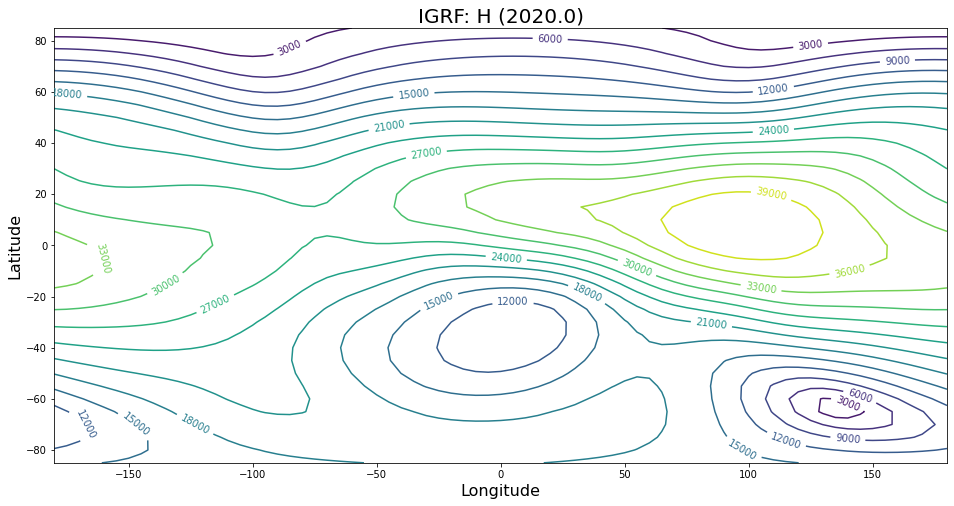

In [12]:
longs  = np.linspace(-180, 180, 73)
lats   = np.linspace(-85, 85, 35)
Bx, By, Bz = zip(*[sha.shm_calculator(gh,13,6371.2,90-lat,lon,'Geocentric') \
                 for lat in lats for lon in longs])
X = np.asarray(Bx).reshape(35,73)
Y = np.asarray(By).reshape(35,73)
Z = np.asarray(Bz).reshape(35,73)
D, H, I, F = [mag.xyz2dhif(X, Y, Z)[el] for el in range(4)]

el_dict={'X':X, 'Y':Y, 'Z':Z, 'D':D, 'H':H, 'I':I, 'F':F}
IGRF_plotter(el2plot, el_dict[el2plot], date)

# Part 2: A more tangible example of modelling using spherical harmonics

In this part we compute spherical harmonic models from an input data set representing a very simple world map with **land** encoded as $1$ and **water** as $0$ (so the data takes the values $0$ and $1$ only). We investigate the ability of models with different choices of maximum spherical harmonic degree to represent the data.

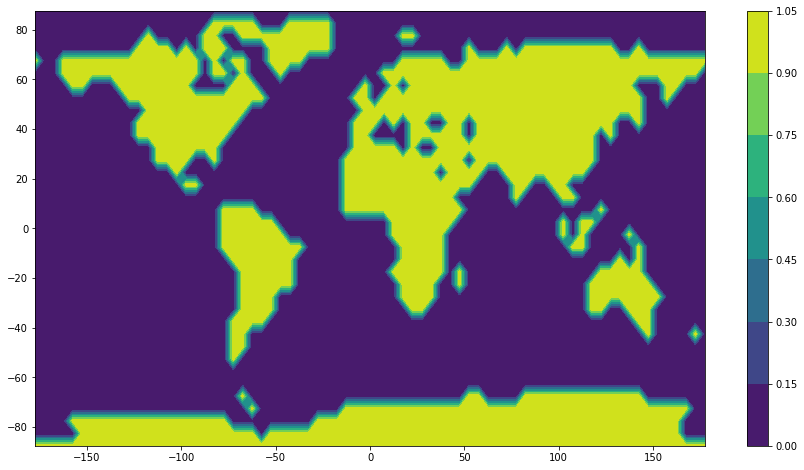

In [13]:
# Load the data
lsdata = np.genfromtxt(lsfile, delimiter=',')

x = lsdata[:,0].reshape(36, 72)
y = lsdata[:,1].reshape(36,72)
z = lsdata[:,2].reshape(36,72)

# Plot them
plt.rcParams['figure.figsize'] = [15, 8]
plt.contourf(x,y,z)
plt.colorbar()
plt.show()

**>> Set the maximum spherical harmonic degree of the analysis:**

In [14]:
nmax = 10 # Max degree

In [15]:
# These functions are used for the spherical harmonic analysis and synthesis steps
# Firstly compute a spherical harmonic model of degree and order nmax using the input data as plotted above
def sh_analysis(lsdata, nmax):
    npar = (nmax+1)*(nmax+1)
    ndat = len(lsdata)
    lhs  = np.zeros(npar*ndat).reshape(ndat,npar)

    rhs  = np.zeros(ndat)
    line = np.zeros(npar)
    ic   = -1
    for i in range(ndat):
        th  = 90 - lsdata[i][1]
        ph  = lsdata[i][0] 
        rhs[i] = lsdata[i][2]
        cmphi, smphi = sha.csmphi(nmax,ph)
        pnm = sha.pnm_calc(nmax, th)
        for n in range(nmax+1):
            igx = sha.gnmindex(n,0)
            ipx = sha.pnmindex(n,0)
            line[igx] = pnm[ipx]
            for m in range(1,n+1):
                igx = sha.gnmindex(n,m)
                ihx = sha.hnmindex(n,m)
                ipx = sha.pnmindex(n,m)
                line[igx] = pnm[ipx]*cmphi[m]
                line[ihx] = pnm[ipx]*smphi[m]
        lhs[i,:] = line

    shmod  = np.linalg.lstsq(lhs, rhs.reshape(len(lsdata),1), rcond=None)
    return(shmod)


# Now use the model to synthesise values on a 5 degree grid in latitude and longitude
def sh_synthesis(shcofs, nmax):
    newdata =np.zeros(72*36*3).reshape(2592,3)
    ic = 0
    for ilat in range(36):
        delta = 5*ilat+2.5
        lat = 90 - delta
        for iclt in range(72):
            corr  = 5*iclt+2.5
            long  = -180+corr
            colat = 90-lat
            cmphi, smphi = sha.csmphi(nmax,long)
            vals  = np.dot(sha.gh_phi(shcofs, nmax, cmphi, smphi), sha.pnm_calc(nmax, colat))
            newdata[ic,0]=long
            newdata[ic,1]=lat
            newdata[ic,2]=vals
            ic += 1
    return(newdata)

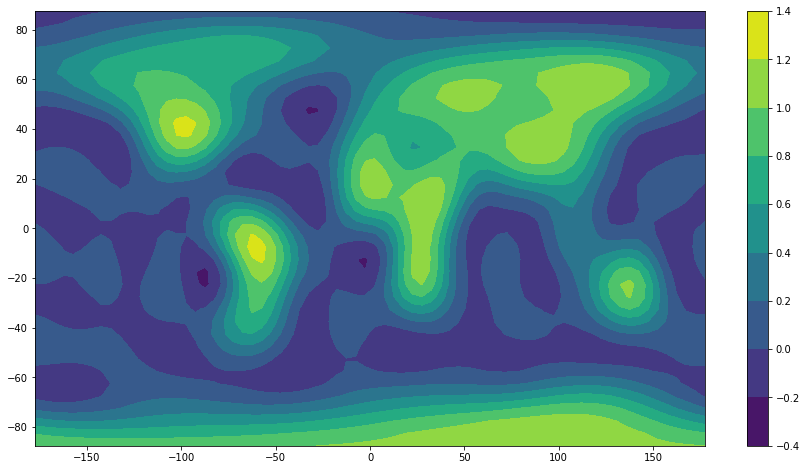

In [16]:
# Obtain the spherical harmonic coefficients
shmod = sh_analysis(lsdata=lsdata, nmax=nmax)

# Read the model coefficients
shcofs = shmod[0]

# Synthesise the model coefficients on a 5 degree grid
newdata = sh_synthesis(shcofs=shcofs, nmax=nmax)
# Reshape for plotting purposes
x = newdata[:,0].reshape(36, 72)
y = newdata[:,1].reshape(36,72)
z = newdata[:,2].reshape(36,72)

# Plot the results
plt.rcParams['figure.figsize'] = [15, 8]
levels = [-1.5, -0.75, 0, 0.25, 0.5, 0.75, 2.]
plt.contourf(x,y,z)
plt.colorbar()
plt.show()

# Spherical harmonic models with data gaps

In this section, we can remove data within a spherical cap of specified radius and pole position.

In [17]:
def greatcircle(th1, ph1, th2, ph2):
    th1 = np.deg2rad(th1)
    th2 = np.deg2rad(th2)
    dph = np.deg2rad(dlong(ph1,ph2))

  # Apply the cosine rule of spherical trigonometry
    dth = np.arccos(np.cos(th1)*np.cos(th2) + \
              np.sin(th1)*np.sin(th2)*np.cos(dph))
    return(dth)

def dlong (ph1, ph2):
    ph1 = np.sign(ph1)*abs(ph1)%360   # These lines return a number in the 
    ph2 = np.sign(ph2)*abs(ph2)%360   # range -360 to 360
    if(ph1 < 0): ph1 = ph1 + 360      # Put the results in the range 0-360
    if(ph2 < 0): ph2 = ph2 + 360
    dph = max(ph1,ph2) - min(ph1,ph2) # So the answer is positive and in the
                                      # range 0-360
    if(dph > 180): dph = 360-dph      # So the 'short route' is returned
    return(dph)

def gh_phi(gh, nmax, cp, sp):
    rx = np.zeros(nmax*(nmax+3)//2+1)
    igx=-1
    igh=-1
    for i in range(nmax+1):
        igx += 1
        igh += 1
        rx[igx]= gh[igh]
        for j in range(1,i+1):
            igh += 2
            igx += 1
            rx[igx] = (gh[igh-1]*cp[j] + gh[igh]*sp[j])
    return(rx)

**>> Set the location and size of the data gap:**

Enter the pole colatitude and longitude in degrees and the radius in $km$

In [18]:
# Remove a section of data centered on colat0, long0 and radius='radius':
colat0  = 113
long0   = 135
radius  = 3000

Blanked out:  104


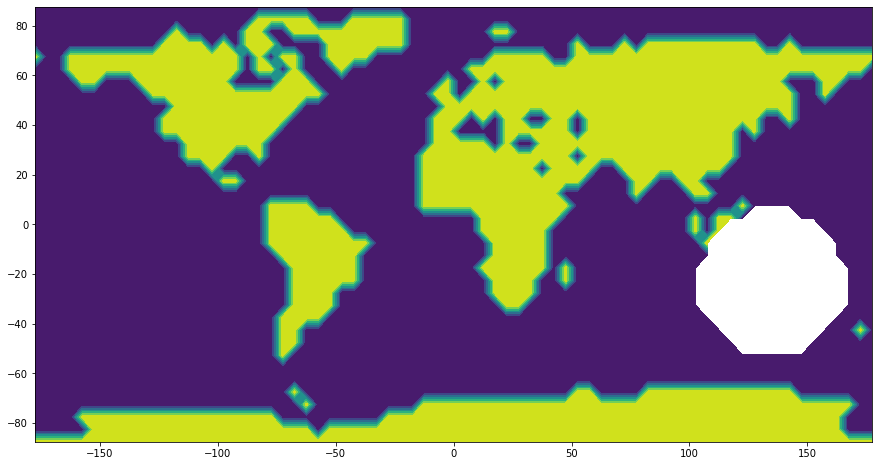

In [19]:
lsdata_gap = lsdata.copy()
for row in range(len(lsdata_gap)):
    colat = 90 - lsdata_gap[row,1]
    long  = lsdata_gap[row,0]
    if greatcircle(colat, long, colat0, long0) < radius/6371.2:
        lsdata_gap[row,2] = np.nan

print('Blanked out: ', np.count_nonzero(np.isnan(lsdata_gap)))

x_gap = lsdata_gap[:,0].reshape(36, 72)
y_gap = lsdata_gap[:,1].reshape(36,72)
z_gap = lsdata_gap[:,2].reshape(36,72)

# Plot the map with omitted data
plt.contourf(x_gap, y_gap, z_gap)

**>> Set the maximum spherical harmonic degree of the analysis:**

In [20]:
nmax = 12 #Max degree

In [21]:
# Select the non-nan data
lsdata_gap = lsdata_gap[~np.isnan(lsdata_gap[:,2])]

# Obtain the spherical harmonic coefficients for the incomplete data set
shmod = sh_analysis(lsdata=lsdata_gap, nmax=nmax)

# Read the model coefficients
shcofs = shmod[0]

# Synthesise the model coefficients on a 5 degree grid
newdata = sh_synthesis(shcofs=shcofs, nmax=nmax)
# Reshape for plotting purposes
x_new = newdata[:,0].reshape(36, 72)
y_new = newdata[:,1].reshape(36,72)
z_new = newdata[:,2].reshape(36,72)

**>> Print the maximum and minimum of the synthesised data:**

In [22]:
print(np.min(z_new))
print(np.max(z_new))

-0.25531903688873847
5.853211492921415


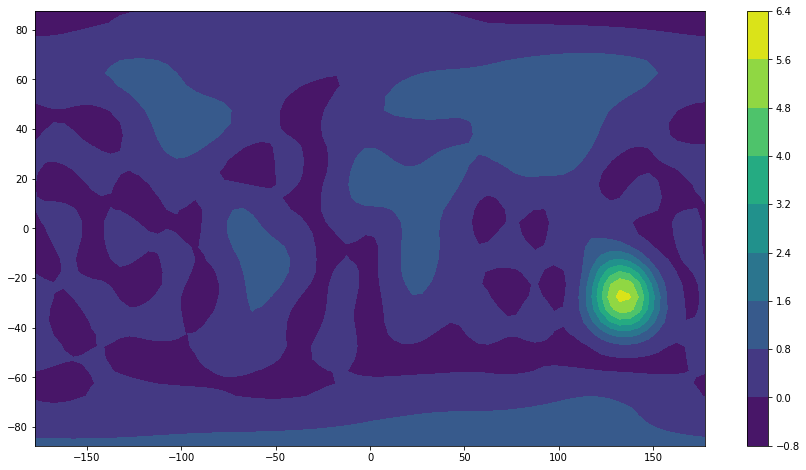

In [23]:
# Plot the results with colour scale according to the data
plt.rcParams['figure.figsize'] = [15, 8]
plt.contourf(x_new, y_new, z_new)
plt.colorbar()
plt.show()

Now let see what happens when we restrict the colour scale to values between 0 and 1 (so values <0 and >1 are compressed into opposite ends of the colour scale).

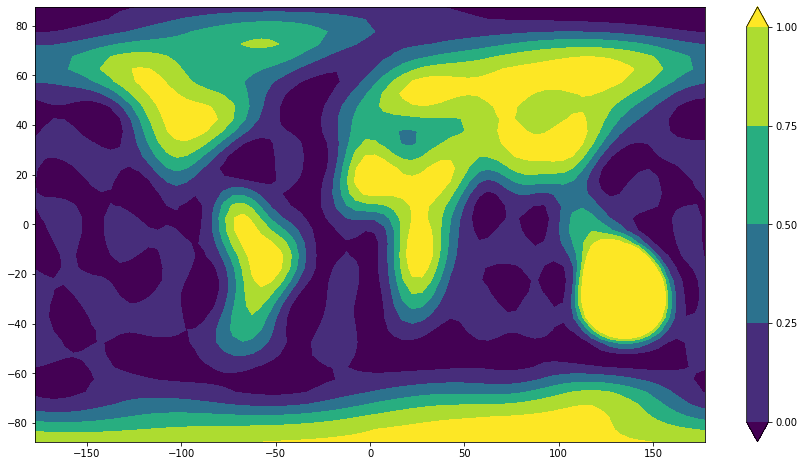

In [24]:
# Plot the results
plt.rcParams['figure.figsize'] = [15, 8]
levels = [0, 0.25, 0.5, 0.75, 1.]
plt.contourf(x_new, y_new, z_new, levels, extend='both')
plt.colorbar()
plt.show()

# Making a spherical harmonic model of the geomagnetic field

There is a file containing $Virtual$ $Observatory$ ($VO$) data calculated from the $Swarm$ 3-satellite constellation in this repository. $VOs$ use a local method to provide point estimates of the magnetic field at a specified time and fixed location at satellite altitude. This technique has various benefits, including:

1- Easier comparison between satellite (moving instrument) and ground observatory (fixed instrument) data, which is particularly useful when studying time changes of the magnetic field, e.g. geomagnetic jerks.

2- One can compute $VOs$ on a regular spatial grid to mitigate the effects of uneven ground observatory coverage.

A brief summary of the method used to calculate each of these VO data points:
- Swarm track data over four months are divided into $300$ globally distributed equal area bins
- Gross outliers (deviating over 500nT from the CHAOS-6-x7 internal field model) are removed
- Only data from magnetically quiet, dark times are kept
- Estimates of the core and crustal fields from CHAOS-6-x7 are subtracted from each datum to give the residuals
- A local magnetic potential $V$ nis fit to the residuals within the cylinder
- Values of the residual magnetic field in spherical coordinates ($r$, $\theta$, $\phi$) are computed from the obtained magnetic potential using  at centre of the bin (at 490km altitude)
- An estimate of the modelled core field at the VO calculation point is added back onto the residual field to give the total internal magnetic field value

In this section, we use VO data centred on $2015.0$ to produce a degree $13$ spherical harmonic model of the geomagnetic field and compare our (satellite data only) model to the IGRF (computed using both ground and satellite data) at $2015.0$.


In [25]:
# Read in the VO data
cols  = ['Year','Colat','Long','Rad','Br','Bt', 'Bp']
bvals = pd.read_csv(cfile, sep='\s+', skiprows=0, header=None, index_col=0,
                    na_values=[99999.00,99999.00000], names=cols, comment='%')
bvals = bvals.dropna()
bvals['Bt']= -bvals['Bt']
bvals['Br']= -bvals['Br']
colnames=['Colat','Long','Rad','Bt','Bp', 'Br']
bvals=bvals.reindex(columns=colnames)
bvals.columns = ['Colat','Long','Rad','X','Y','Z']
print(bvals.info())
# Set the date to 2015.0 (this is the only common date between the VO data file and the IGRF coefficients file)
epoch = 2015.0
# Set the model resolution to 13 (the same as IGRF)
nmax = 13

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1444 entries, 2014.0 to 2018.0
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Colat   1444 non-null   float64
 1   Long    1444 non-null   float64
 2   Rad     1444 non-null   float64
 3   X       1444 non-null   float64
 4   Y       1444 non-null   float64
 5   Z       1444 non-null   float64
dtypes: float64(6)
memory usage: 79.0 KB
None


In [26]:
def geomagnetic_model(epoch, nmax, data, RREF=6371.2):
    # Select the data for that date
    colat =  np.array(data.loc[epoch]['Colat'])
    nx   = len(colat) # Number of data triples
    ndat = 3*nx    # Total number of data
    elong =  np.array(data.loc[epoch]['Long'])
    rad   =  np.array(data.loc[epoch]['Rad'])
    rhs   =  data.loc[epoch][['X', 'Y', 'Z']].values.reshape(ndat,1)
    npar = (nmax+1)*(nmax+1) # Number of model parameters
    nx   = len(colat) # Number of data triples
    ndat = 3*nx    # Total number of data
    print('Number of data triples selected =', nx)

    # Arrays for the equations of condition
    lhs  = np.zeros(npar*ndat).reshape(ndat,npar)
    linex = np.zeros(npar); liney = np.zeros(npar); linez = np.zeros(npar)

    iln = 0 # Row counter
    for i in range(nx): # Loop over data triplets (X, Y, Z)
        r  = rad[i]
        th = colat[i]; ph  = elong[i] 
        rpow = sha.rad_powers(nmax, RREF, r)
        cmphi, smphi = sha.csmphi(nmax, ph)
        pnm, xnm, ynm, znm = sha.pxyznm_calc(nmax, th)

        for n in range(nmax+1): # m=0
            igx = sha.gnmindex(n,0) # Index for g(n,0) in gh conventional order
            ipx = sha.pnmindex(n,0) # Index for pnm(n,0) in array pnm
            rfc = rpow[n]
            linex[igx] =  xnm[ipx]*rfc
            liney[igx] =  0
            linez[igx] = znm[ipx]*rfc

            for m in range(1,n+1): # m>0
                igx = sha.gnmindex(n,m) # Index for g(n,m)
                ihx = igx + 1           # Index for h(n,m)
                ipx = sha.pnmindex(n,m) # Index for pnm(n,m)
                cpr = cmphi[m]*rfc
                spr = smphi[m]*rfc
                linex[igx] =  xnm[ipx]*cpr; linex[ihx] =  xnm[ipx]*spr
                liney[igx] =  ynm[ipx]*spr; liney[ihx] = -ynm[ipx]*cpr
                linez[igx] =  znm[ipx]*cpr; linez[ihx] =  znm[ipx]*spr

        lhs[iln,  :] = linex
        lhs[iln+1,:] = liney
        lhs[iln+2 :] = linez
        iln += 3

    shmod = np.linalg.lstsq(lhs, rhs, rcond=None) # Include the monopole
    # shmod = np.linalg.lstsq(lhs[:,1:], rhs, rcond=None) # Exclude the monopole
    gh = shmod[0]
    return(gh)

In [27]:
coeffs = geomagnetic_model(epoch=epoch, nmax=nmax, data=bvals)

Number of data triples selected = 299


**>> Read in the IGRF coefficients for comparison:**

In [28]:
igrf13 = pd.read_csv(IGRF13_FILE, delim_whitespace=True,  header=3)

In [29]:
igrf13.head()

,g/h,n,m,1900.0,1905.0,1910.0,1915.0,1920.0,1925.0,1930.0,...,1980.0,1985.0,1990.0,1995.0,2000.0,2005.0,2010.0,2015.0,2020.0,2020-25
0,g,1,0,-31543,-31464,-31354,-31212,-31060,-30926,-30805,...,-29992,-29873,-29775,-29692,-29619.4,-29554.63,-29496.57,-29441.46,-29404.8,5.7
1,g,1,1,-2298,-2298,-2297,-2306,-2317,-2318,-2316,...,-1956,-1905,-1848,-1784,-1728.2,-1669.05,-1586.42,-1501.77,-1450.9,7.4
2,h,1,1,5922,5909,5898,5875,5845,5817,5808,...,5604,5500,5406,5306,5186.1,5077.99,4944.26,4795.99,4652.5,-25.9
3,g,2,0,-677,-728,-769,-802,-839,-893,-951,...,-1997,-2072,-2131,-2200,-2267.7,-2337.24,-2396.06,-2445.88,-2499.6,-11.0
4,g,2,1,2905,2928,2948,2956,2959,2969,2980,...,3027,3044,3059,3070,3068.4,3047.69,3026.34,3012.20,2982.0,-7.0


In [30]:
# Select the 2015 IGRF coefficients
igrf = np.array(igrf13[str(epoch)])
# Insert a zero in place of the monopole coefficient (this term is NOT included in the IRGF, or any other field model)
igrf = np.insert(igrf, 0, 0)

**>> Compare our model coefficients to IGRF13:**

In [33]:
print("VO model \t   IGRF13")
for i in range(196):
    print("% 9.1f\t%9.1f" %(coeffs[i], igrf[i]))

VO model 	   IGRF13
     -0.3	      0.0
 -29441.9	 -29441.5
  -1502.9	  -1501.8
   4784.9	   4796.0
  -2444.7	  -2445.9
   3012.8	   3012.2
  -2826.6	  -2845.4
   1676.4	   1676.3
   -640.9	   -642.2
   1351.9	   1350.3
  -2352.0	  -2352.3
   -135.5	   -115.3
   1225.7	   1225.8
    245.0	    245.0
    582.6	    581.7
   -538.8	   -538.7
    907.9	    907.4
    813.9	    813.7
    304.4	    283.5
    120.9	    120.5
   -189.0	   -188.4
   -335.3	   -334.9
    180.7	    180.9
     70.7	     70.4
   -329.0	   -329.2
   -233.0	   -232.9
    359.9	    360.1
     23.9	     47.0
    192.4	    192.3
    196.8	    197.0
   -141.0	   -140.9
   -119.1	   -119.1
   -157.5	   -157.4
     15.7	     16.0
      3.9	      4.3
    100.1	    100.1
     69.5	     69.5
     68.0	     67.6
      4.3	    -20.6
     72.9	     72.8
     33.5	     33.3
   -130.0	   -129.8
     58.9	     58.7
    -28.9	    -28.9
    -66.6	    -66.6
     13.2	     13.1
      7.3	      7.3
    -71.0	    -70.8
     62.4	     62.4
